1. Loading statements from Nitin and Edgar 

2. Combining statements from Nitin and Edgar

3. Selecting unique and non-NA statements

4. Text processing and cleaning  
  
  4.1 Initial text preprocessing
    * extracting and removing urls from text
    * fixing word contractions, for ex. they'll -> they will
    * uk to us conversion, for ex. organisation -> organization
    * removing sentences with words "privacy", "cookies"
    * removing stopwords, special characters
    * removing company name from the statement - company name in the statement is not relevant for textual analysis
  
  4.2 Lemmatization and filtering words with word-size between 2 and 15
    
5. Generating similarity score between statements and removing 99% duplicate statements

6. Finding a threshold length to check whether a statement is modern slavery statement or scrap statement

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from os import getcwd
import numpy as np
from tqdm import tqdm
import re
from typing import Tuple, Dict, Sequence, List, Union
from copy import deepcopy
from urlextract import URLExtract
from nltk.stem import WordNetLemmatizer
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from modern_slavery_registry import text_parser, utils

In [4]:
PROJECT_PATH = getcwd()
PROJECT_PATH = PROJECT_PATH.replace("\\notebooks", "")
DATA_PATH = PROJECT_PATH +  "\\data"
SHEETS_PATH = DATA_PATH + "\\sheets"
RANDOM_STATE = 42

# 1. Loading modern slavery statements from Edgar and Nitin

In [5]:
prof_data = pd.read_json(f"{SHEETS_PATH}\\modern_slavery_dataset_prof.json")
cols_to_keep = ["Company ID", "Company", "Statement ID", "URL", "Text"]
prof_data.drop_duplicates(inplace=True)
prof_data.dropna(subset=["Company ID"], inplace=True)
prof_data.reset_index(drop=True, inplace=True)
prof_data = prof_data[cols_to_keep]
cols_type = ["int32", str, float, str, str]
for i, col in enumerate(prof_data.columns):
    prof_data[col] = prof_data[col].astype(cols_type[i])
prof_data.rename(columns = {"Text": "statement(Edgar)"},  
                 inplace = True) 



my_data = pd.read_excel(f"{SHEETS_PATH}\\modern_slavery_dataset_nitin.xlsx")
cols_to_keep = ["Company ID", "Company", "Statement ID", "URL", "statement"]
my_data.drop_duplicates(inplace=True)
my_data.dropna(subset=["Company ID"], inplace=True)
my_data.reset_index(drop=True, inplace=True)
my_data = my_data[cols_to_keep]
for i, col in enumerate(my_data.columns):
    my_data[col] = my_data[col].astype(cols_type[i])
my_data.rename(columns = {"statement": "statement(Nitin)"},  
               inplace = True)

print(f"Total statements (non-NA and NA) Edgar: {len(prof_data)}, Nitin: {len(my_data)} ")

Total statements (non-NA and NA) Edgar: 28361, Nitin: 27527 


In [6]:
prof_data.head(3)

,Company ID,Company,Statement ID,URL,statement(Edgar)
0,7676,"""K"" Line Holding Europe Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
1,28660,"""K"" Line Bulk Shipping (UK) Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...
2,28659,"""K"" Line (Europe) Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...


In [7]:
my_data.head(3)

,Company ID,Company,Statement ID,URL,statement(Nitin)
0,7676,"""K"" Line Holding Europe Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,66 99 “K” Line Holding (Europe) Limited kM K L...
1,28660,"""K"" Line Bulk Shipping (UK) Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,66 99 “K” Line Holding (Europe) Limited kM K L...
2,28659,"""K"" Line (Europe) Limited",35092.0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,66 99 “K” Line Holding (Europe) Limited kM K L...


# 2. Combining both datasets 

In [8]:
combine_data = pd.merge(prof_data,
                        my_data,
                        on = ["Company ID", "Company", "Statement ID", "URL"], 
                        how = "outer")
combine_data.drop_duplicates(inplace=True)
combine_data.reset_index(drop=True, inplace=True)
combine_data.fillna("#NA", inplace=True)
combine_data["statement(Edgar)"] = ["#NA" if text in ("nan", "None") or text == "" else text for text in combine_data["statement(Edgar)"]]
combine_data["statement(Nitin)"] = ["#NA" if text in ("nan", "None") or text == "" else text for text in combine_data["statement(Nitin)"]]

PRIMARY = "Nitin"
if PRIMARY == "Nitin":
    secondary = "Edgar"
    primary_code = "N"
    secondary_code = "E"
else:
    secondary = "Nitin"
    primary_code = "E"
    secondary_code = "N"
    
    
statements = [
    (primary_code, combine_data[f"statement({PRIMARY})"].iloc[i]) if combine_data[f"statement({PRIMARY})"].iloc[i] != "#NA" else 
    (secondary_code, combine_data[f"statement({secondary})"].iloc[i]) for i in range(len(combine_data))
]

choice = [_[0] for _ in statements]
statements = [_[1] for _ in statements]
combine_data["final_statement"] = statements
combine_data["final_statement(E/N)"] = choice

In [9]:
combine_data.head()

,Company ID,Company,Statement ID,URL,statement(Edgar),statement(Nitin),final_statement,final_statement(E/N)
0,7676,"""K"" Line Holding Europe Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 “K” Line Holding (Europe) Limited kM K L...,66 99 “K” Line Holding (Europe) Limited kM K L...,N
1,28660,"""K"" Line Bulk Shipping (UK) Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 “K” Line Holding (Europe) Limited kM K L...,66 99 “K” Line Holding (Europe) Limited kM K L...,N
2,28659,"""K"" Line (Europe) Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 “K” Line Holding (Europe) Limited kM K L...,66 99 “K” Line Holding (Europe) Limited kM K L...,N
3,28661,"""K"" Line LNG Shipping Limited",35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 “K” Line Holding (Europe) Limited kM K L...,66 99 “K” Line Holding (Europe) Limited kM K L...,N
4,28658,Polar LNG Shipping (UK) Limited,35092,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,K LINE\nHOLDINC (EUROPE) LTD.\nModern Slavery ...,66 99 “K” Line Holding (Europe) Limited kM K L...,66 99 “K” Line Holding (Europe) Limited kM K L...,N


In [10]:
print("Before cleaning")
print(f"Total final statements: {len(combine_data)}")
print(f"Total NA final_statements: {np.sum((combine_data['final_statement'] == '#NA'))}")
print(f"Total non-NA final_statements: {np.sum((combine_data['final_statement'] != '#NA'))}")
print("Total non-NA final_statements(E): "
      f"{np.sum((combine_data['final_statement'] != '#NA') & (combine_data['final_statement(E/N)'] == 'E'))}")
print("Total non-NA final_statements(N): "
      f"{np.sum((combine_data['final_statement'] != '#NA') & (combine_data['final_statement(E/N)'] == 'N'))}")

Before cleaning
Total final statements: 28364
Total NA final_statements: 7663
Total non-NA final_statements: 20701
Total non-NA final_statements(E): 2365
Total non-NA final_statements(N): 18336


# 3.  Selecting unique statements

In [11]:
subset_data = combine_data[combine_data["final_statement"]!="#NA"][["URL", "Company", "final_statement"]].copy()
subset_data.drop_duplicates(subset="URL", inplace=True)
subset_data.head()

,URL,Company,final_statement
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,"""K"" Line Holding Europe Limited",66 99 “K” Line Holding (Europe) Limited kM K L...
10,https://1spatial.com/who-we-are/legal/modern-s...,1Spatial Plc,1Spatial Modern Slavery Act Policy Statement H...
11,https://www.shazans.com/slavery-and-human-traf...,1Stop Halal Limited,Slavery and Human Trafficking Statement – Shaz...
12,https://www.business-humanrights.org/sites/def...,1st Step Solutions Limited,7/28/2019 Modern Slavery Statement 2018 - 1st ...
13,https://www.2agriculture.com/wp-content/upload...,2 Agriculture Limited,fh Modern Slavery Act 2015: slavery and human ...


In [12]:
print(f"Unique non-NA statements in subset data: {len(subset_data)}")

Unique non-NA statements in subset data: 11969


# 4. Text Cleaning and Preprocessing

### 4.1 Initial text preprocessing

In [13]:
uk_to_us_mappings = pd.read_excel(f"{DATA_PATH}\\UK_to_US_word_mappings.xlsx")
uk_to_us_mappings = {row[0]: row[1] for row in  uk_to_us_mappings.values}

url_extractor = URLExtract()

In [14]:
def clean_text(text: str):
    text = text.lower()
    text = text.replace("\n"," ")
    text = text.replace("\t"," ")
    urls = url_extractor.find_urls(text)
    for url in urls:
        text = text.replace(url, " ")
    text = " ".join([text_parser.word_expantions[word] if word in text_parser.word_expantions else word for word in text.split()])
    text = " ".join([uk_to_us_mappings[word] if word in uk_to_us_mappings else word for word in text.split()])
    remove_tokens = [["privacy", "policy"], "cookies"]
    text = text_parser.remove_sentences_with_tokens(text, tokens=remove_tokens)
    text = text_parser.replace_special_chars(text, replace_digits=True)
    text = text_parser.remove_stopwords(text)
    return text

In [15]:
subset_data["final_statement_cleaned"] = [
    clean_text(statement) for statement in tqdm(subset_data["final_statement"], position=0, leave=True)]
subset_data = subset_data[subset_data["final_statement_cleaned"] != ""]
print(f"Unique non-NA cleaned statements in subset data: {len(subset_data)}")

100%|████████████████████████████████████████████████████████████████████████████| 11969/11969 [16:59<00:00, 11.74it/s]

Unique non-NA cleaned statements in subset data: 11937


In [16]:
subset_data["company_cleaned"] = [clean_text(company) for company in tqdm(subset_data["Company"], position=0, leave=True)]

100%|██████████████████████████████████████████████████████████████████████████| 11937/11937 [00:04<00:00, 2760.64it/s]


In [17]:
subset_data.head()

,URL,Company,final_statement,final_statement_cleaned,company_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,"""K"" Line Holding Europe Limited",66 99 “K” Line Holding (Europe) Limited kM K L...,k line holding europe limited km k line sh foo...,k line holding europe limited
10,https://1spatial.com/who-we-are/legal/modern-s...,1Spatial Plc,1Spatial Modern Slavery Act Policy Statement H...,spatial modern slavery act policy statement ho...,spatial plc
11,https://www.shazans.com/slavery-and-human-traf...,1Stop Halal Limited,Slavery and Human Trafficking Statement – Shaz...,slavery human trafficking statement shazans sh...,stop halal limited
12,https://www.business-humanrights.org/sites/def...,1st Step Solutions Limited,7/28/2019 Modern Slavery Statement 2018 - 1st ...,modern slavery statement st step solutions e r...,st step solutions limited
13,https://www.2agriculture.com/wp-content/upload...,2 Agriculture Limited,fh Modern Slavery Act 2015: slavery and human ...,fh modern slavery act slavery human traffickin...,agriculture limited


In [18]:
def remove_company_name(company_name: str, 
                        statement: str) -> str:
    """Remove company name instances present in the statement."""
    mappings = text_parser.find_ngrams_in_text(sentence=company_name,
                                   text=statement)
    # to remove big text first
    mappings = {k:v for k,v in sorted(mappings.items(), key=lambda x:x[1])} 
    for ngram, cnt in mappings.items():
        if cnt > 0:
            ngram_splitted = ngram.split()
            # to skip unigram of length 1 and single character in unigram
            if not (len(ngram_splitted) == 1 and len(ngram_splitted[0]) == 1): 
                statement = statement.replace(ngram," ")

    statement = " ".join(statement.split())
    return statement

In [19]:
subset_data["final_statement_cleaned"] = [remove_company_name(company_name=row[0], 
                                                              statement=row[1]) 
                                          for row in tqdm(subset_data[["company_cleaned",
                                                                       "final_statement_cleaned"]].values,
                                                          position=0, 
                                                          leave=True)]
subset_data = deepcopy(subset_data[subset_data["final_statement_cleaned"] != ""])
subset_data.drop("company_cleaned", axis=1, inplace=True)
subset_data.head()

100%|██████████████████████████████████████████████████████████████████████████| 11937/11937 [00:10<00:00, 1097.96it/s]


,URL,Company,final_statement,final_statement_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,"""K"" Line Holding Europe Limited",66 99 “K” Line Holding (Europe) Limited kM K L...,km sh foor eum holding europe ltd aldersgate s...
10,https://1spatial.com/who-we-are/legal/modern-s...,1Spatial Plc,1Spatial Modern Slavery Act Policy Statement H...,modern slavery act policy statement home solut...
11,https://www.shazans.com/slavery-and-human-traf...,1Stop Halal Limited,Slavery and Human Trafficking Statement – Shaz...,slavery human trafficking statement shazans sh...
12,https://www.business-humanrights.org/sites/def...,1st Step Solutions Limited,7/28/2019 Modern Slavery Statement 2018 - 1st ...,modern slavery atement e r n l v e r e e n ate...
13,https://www.2agriculture.com/wp-content/upload...,2 Agriculture Limited,fh Modern Slavery Act 2015: slavery and human ...,fh modern slavery act slavery human traffickin...


In [20]:
print(f"Unique non-NA cleaned statements in subset data: {len(subset_data)}")

Unique non-NA cleaned statements in subset data: 11937


### 4.2 Lemmatizing

In [21]:
lemmatizer = WordNetLemmatizer() # wordnet lemmatizer object
cleaned_statements = []
for statement in tqdm(subset_data["final_statement_cleaned"], position=0, leave=True):
    cleaned_statements.append(
        " ".join(
            lemmatizer.lemmatize(word, pos="v") for word in statement.split()))

100%|███████████████████████████████████████████████████████████████████████████| 11937/11937 [00:55<00:00, 215.96it/s]


In [22]:
word_sizes = {}
vocab = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if word not in vocab:
            vocab[word] = 1
        else:
            vocab[word] += 1
        if size not in word_sizes:
            word_sizes[size] = 1
        else:
            word_sizes[size] += 1
word_sizes = utils.sort_dict(word_sizes, by=0)
print(f"Total vocab size: {len(vocab)}, total distinct word sizes: {len(word_sizes)}")

100%|██████████████████████████████████████████████████████████████████████████| 11937/11937 [00:08<00:00, 1422.48it/s]

Total vocab size: 75740, total distinct word sizes: 77


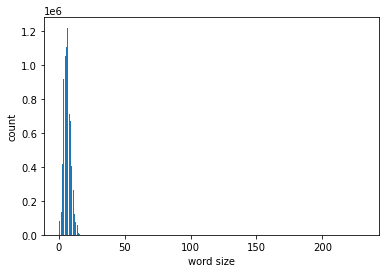

In [23]:
fig, ax = plt.subplots()
ax.bar(word_sizes.keys(), word_sizes.values())
ax.set_xlabel("word size")
ax.set_ylabel("count")
plt.show()

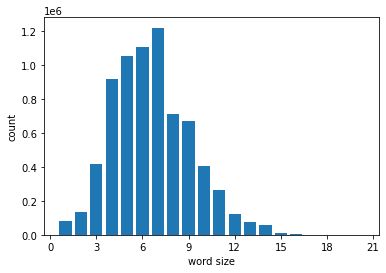

In [24]:
fig, ax = plt.subplots()
upper_limit = 20
ax.bar(list(word_sizes.keys())[:upper_limit], list(word_sizes.values())[:upper_limit])
ax.set_xlabel("word size")
ax.set_ylabel("count")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

From above plot, it seems like max word size can be restricted to 15 and min word size to 2

In [25]:
MIN_WORD_SIZE = 2
MAX_WORD_SIZE = 15

In [26]:
temp_cleaned_statements = []
for statement in tqdm(cleaned_statements, position=0, leave=True):
    temp_cleaned_statements.append(
        " ".join([word for word in statement.split() 
                  if MIN_WORD_SIZE <= len(word) <= MAX_WORD_SIZE]))
cleaned_statements = deepcopy(temp_cleaned_statements)
del temp_cleaned_statements

100%|██████████████████████████████████████████████████████████████████████████| 11937/11937 [00:03<00:00, 3811.28it/s]


In [27]:
sub_word_sizes = {}
sub_vocab = {}
for statement in tqdm(cleaned_statements, position=0, leave=True):
    for word in statement.split():
        size = len(word)
        if word not in sub_vocab:
            sub_vocab[word] = 1
        else:
            sub_vocab[word] += 1
        if size not in sub_word_sizes:
            sub_word_sizes[size] = 1
        else:
            sub_word_sizes[size] += 1
            
sub_word_sizes = utils.sort_dict(sub_word_sizes, by=0)
sub_vocab = utils.sort_dict(sub_vocab, by=1, reverse=True)
print(f"Total vocab size: {len(sub_vocab)}, total distinct word sizes: {len(sub_word_sizes)}")

100%|██████████████████████████████████████████████████████████████████████████| 11937/11937 [00:08<00:00, 1425.87it/s]

Total vocab size: 73354, total distinct word sizes: 14


In [28]:
subset_data["final_statement_cleaned"] = cleaned_statements
subset_data = subset_data[subset_data["final_statement_cleaned"] != ""]
subset_data.head()

,URL,Company,final_statement,final_statement_cleaned
0,https://img1.wsimg.com/blobby/go/7695baff-3f0f...,"""K"" Line Holding Europe Limited",66 99 “K” Line Holding (Europe) Limited kM K L...,km sh foor eum hold europe ltd aldersgate stre...
10,https://1spatial.com/who-we-are/legal/modern-s...,1Spatial Plc,1Spatial Modern Slavery Act Policy Statement H...,modern slavery act policy statement home solut...
11,https://www.shazans.com/slavery-and-human-traf...,1Stop Halal Limited,Slavery and Human Trafficking Statement – Shaz...,slavery human traffic statement shazans shazan...
12,https://www.business-humanrights.org/sites/def...,1st Step Solutions Limited,7/28/2019 Modern Slavery Statement 2018 - 1st ...,modern slavery atement atement make pursuant s...
13,https://www.2agriculture.com/wp-content/upload...,2 Agriculture Limited,fh Modern Slavery Act 2015: slavery and human ...,fh modern slavery act slavery human traffic st...


In [29]:
print(f"Unique non-NA cleaned statements in subset data: {len(subset_data)}")

Unique non-NA cleaned statements in subset data: 11937


# 5. Generating similarity score between statements and removing 99% duplicate statements

In [30]:
N_GRAM = (1, 1)
count_vect = CountVectorizer(ngram_range=N_GRAM)
X = count_vect.fit_transform(subset_data["final_statement_cleaned"])
print(f"Count vector shape: {X.shape}")

Count vector shape: (11937, 73354)


In [31]:
similarity_matrix = cosine_similarity(X, X)

In [32]:
DUPLICATE_SIMILARITY_SCORE_THRESHOLD = .99
n = X.shape[0]
dup_mapping = {} 
dup_idxs = []
for idx in tqdm(range(n), position=0, leave=True):
    if idx not in dup_idxs:
        idxs = np.argwhere(similarity_matrix[idx][idx+1:] > DUPLICATE_SIMILARITY_SCORE_THRESHOLD).ravel()
        if len(idxs) > 0:
            idxs += idx+1 # shifting
            dup_mapping[idx] = idxs
            dup_idxs += list(idxs)

100%|██████████████████████████████████████████████████████████████████████████| 11937/11937 [00:02<00:00, 4714.45it/s]


In [33]:
print(f"Found {len(dup_idxs)} out of {len(subset_data)} with {DUPLICATE_SIMILARITY_SCORE_THRESHOLD*100}% duplicacy")

Found 1121 out of 11937 with 99.0% duplicacy


In [ ]:
subset_data[f"{DUPLICATE_SIMILARITY_SCORE_THRESHOLD}_per_duplicate"] = [True if idx in dup_idxs else False for idx in tqdm(range(n))]
subset_data = subset_data[subset_data["0.99_per_duplicate"]==False]
subset_data.head()

 25%|██████████████████▍                                                        | 2937/11937 [00:00<00:02, 3260.76it/s]

In [ ]:
print(f"Unique non-NA cleaned statements in subset data: {len(subset_data)}")

In [ ]:
list(dup_mapping.items())[2]

In [ ]:
subset_data["final_statement_cleaned"].iloc[101][:500]

In [ ]:
subset_data["final_statement_cleaned"].iloc[102][:500]

In [ ]:
subset_data["URL"].iloc[101], subset_data["URL"].iloc[102]

# 6. Finding a threshold length to validate that a statement is modern slavery statement or scrap text

In [ ]:
subset_data["len(final_statement_cleaned)"] = subset_data["final_statement_cleaned"].apply(lambda x: len(x))

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.boxplot(subset_data["len(final_statement_cleaned)"])
ax2.hist(subset_data["len(final_statement_cleaned)"], bins=100)
plt.show()

In [ ]:
THRESHOLD_LENGTH = 500
scrap_data = subset_data[subset_data["len(final_statement_cleaned)"] < THRESHOLD_LENGTH]
scrap_data.head()

In [ ]:
np.random.seed(RANDOM_STATE)
for i in np.random.choice(scrap_data.index, replace=False, size=5):
    print(f"{i}: {scrap_data['final_statement_cleaned'].loc[i]}")
    print(f"{'-'*100}")

In [ ]:
print(f"Found {len(scrap_data)} scrap statements out of {len(subset_data)} modern slavery statements with {THRESHOLD_LENGTH} threshold length")

In [ ]:
subset_data = subset_data[subset_data["len(final_statement_cleaned)"] >= 500]
print(f"Unique non-NA, cleaned and filtered statements in subset data: {len(subset_data)}")

In [ ]:
subset_data.to_excel(f"{SHEETS_PATH}\\subset_data.xlsx", engine='xlsxwriter', index=False)